# Kap. 7.3.2 Modellierung nichtlinearer, instationärer Prozesse
## Kristallisationsanlage, instationär

In [11]:
from scipy.optimize import fsolve
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Definition der Funktion(en)

In [12]:
# System aus MODELLGLEICHUNGEN ohne differentielle Gleichungen 
# solange Sättigung noch nicht erreicht ist

def EqSys_ohneF(X_var, X_para, M_KS, M_KW):
     
    # (Rück-)Benennung aller verwendeten Prozessgrößen
    [M0, x0s, x0w, M5, x5s, x5w, 
     x3s, x3w, alpha, M_K, x2s_sat] = X_para
    [M1, x1s, x1w, M2, x2s, x2w, M4, x4s, 
     x4w, M6, x6w, M7, x7s, x7w, x6s]  = X_var  # letzter Eintrag x6s
    

    res1 = M0 + M7 - M1              
    res2 = M0*x0s + M7*x7s - M1*x1s  
    res3 = M0*x0w + M7*x7w - M1*x1w  
    res4 = M1 - M2 - M5             
    res7 = M2 - M6                    # Gl.(7, 28a)
    res8 = M2*x2s - M6*x6s            # Gl.(8, 28a)
    res9 = M2*x2w - M6*x6w            # Gl.(9, 28a)
    res10 = M6 - M4 - M7               
    res11 = M6*x6s - M4*x4s - M7*x7s   
    res12 = M6*x6w - M4*x4w - M7*x7w  
    res18 = alpha*M6 - M4             
    res20 = x2s*M_K - M_KS           
    res22 = x2w*M_K - M_KW           
    res23 = x6s - x7s                 
    res24 = x6w - x7w                
   
    # zu minimierender Residuumsvektor
    Res = [res1, res2, res3, res4, res7, res8, res9, res10, 
           res11, res12, res18, res20, res22, res23, res24]
    
    return Res

In [13]:
# System aus MODELLGLEICHUNGEN ohne differentielle Gleichungen 
# sobald Sättigung erreicht ist

def EqSys_mitF(X_var, X_para, M_KS, M_KW):
   
    # (Rück-)Benennung aller verwendeten Prozessgrößen
    [M0, x0s, x0w, M5, x5s, x5w, 
     x3s, x3w, alpha, M_K, x6s] = X_para      # x6s = x2s_sat Gl.(28b)
    [M1, x1s, x1w, M2, x2s, x2w, M4, x4s, 
     x4w, M6, x6w, M7, x7s, x7w, M3] = X_var  # letzter Eintrag M3

    res1 = M0 + M7 - M1             
    res2 = M0*x0s + M7*x7s - M1*x1s 
    res3 = M0*x0w + M7*x7w - M1*x1w 
    res4 = M1 - M2 - M5             
    res7 = M2 - M3 - M6             
    res8 = M2*x2s - M3*x3s - M6*x6s 
    res9 = M2*x2w - M3*x3w - M6*x6w  
    res10 = M6 - M4 - M7              
    res11 = M6*x6s - M4*x4s - M7*x7s  
    res12 = M6*x6w - M4*x4w - M7*x7w 
    res18 = alpha*M6 - M4            
    res20 = x2s*M_K - M_KS          
    res22 = x2w*M_K - M_KW          
    res23 = x6s - x7s                
    res24 = x6w - x7w                
   
    # zu minimierender Residuumsvektor
    Res = [res1, res2, res3, res4, res7, res8, res9, res10, 
           res11, res12, res18, res20, res22, res23, res24]
    
    return Res

In [14]:
# Approximation an instationäre Lösung als aufrufbare Funktion

def zeit_iteration(X_para, X_var_0_ohneF, X_var_0_mitF, M_KS, M_KW, t_range):  
    
    x2s = M_KS/M_K   # Salzmassenanteil zu Beginn
    
    M_KS_list = [None] * len(t_range)
    M_KW_list = [None] * len(t_range)
    M1_list = [None] * len(t_range)
    M2_list = [None] * len(t_range)
    M3_list = [0] * len(t_range)       # da M3=0 vor Sättigung
    M4_list = [None] * len(t_range)
    M6_list = [None] * len(t_range)
    M7_list = [None] * len(t_range)
    x2s_list = [None] * len(t_range)
    x2w_list = [None] * len(t_range)
    
    for i, t in enumerate(t_range):
        
        # falls Salzmassenanteil in Strom 2 kleiner als Löslichkeit x2s_sat
        if (x2s <= x2s_sat): 
        
            # Aufruf der Lösungsfunktion für algebraisches Gleichungssystem
            X_var_ohneF = fsolve(lambda X_var_ohneF: 
                                 EqSys_ohneF(X_var_ohneF, X_para, M_KS, M_KW), 
                                 X_var_0_ohneF)
            
            [M1, x1s, x1w, M2, x2s, x2w, M4, x4s, 
             x4w, M6, x6w, M7, x7s, x7w, x6s] = X_var_ohneF

            M_KS_list[i] = M_KS
            M_KW_list[i] = M_KW
            M1_list[i] = M1
            M2_list[i] = M2
            M4_list[i] = M4
            M6_list[i] = M6
            M7_list[i] = M7
            x2s_list[i] = x2s
            x2w_list[i] = x2w
            
            # Aktualisieren der differentiellen Prozessgrößen gemäß 
            # der diskretisierten instationären Differntialgleichungen
            M_KS += delta_t*(M1*x1s - M2*x2s - M5*x5s) 
            M_KW += delta_t*(M1*x1w - M2*x2w - M5*x5w)
            
            # Aktualisierung der algebraischen Variablen
            X_var_0_ohneF = X_var_ohneF

        # falls Salzmassenanteil in Strom 2 größer als Löslichkeit x2s_sat    
        elif (x2s > x2s_sat): 

            X_var_mitF = fsolve(lambda X_var_mitF: 
                                EqSys_mitF(X_var_mitF, X_para, M_KS, M_KW), 
                                X_var_0_mitF)
            
            [M1, x1s, x1w, M2, x2s, x2w, M4, x4s, 
             x4w, M6, x6w, M7, x7s, x7w, M3] = X_var_mitF
            
            M_KS_list[i] = M_KS
            M_KW_list[i] = M_KW
            M1_list[i] = M1
            M2_list[i] = M2
            M3_list[i] = M3
            M4_list[i] = M4
            M6_list[i] = M6
            M7_list[i] = M7
            x2s_list[i] = x2s
            x2w_list[i] = x2w
            
            M_KS += delta_t*(M1*x1s - M2*x2s - M5*x5s) 
            M_KW += delta_t*(M1*x1w - M2*x2w - M5*x5w)
            
            X_var_0_mitF = X_var_mitF

            
    return (M_KS_list, M_KW_list, M1_list, 
            M2_list, M3_list, M4_list, M6_list, 
            M7_list, x2s_list, x2w_list)

# Eingabe der Werte

In [15]:
'''
alle Größen: 
t = Zeit [s]
M = Massenstrom [kg/s]
M_ = Masse [kg]
x = Massenanteil in Strom [-]
alpha = Splitfaktor [-]

einige Indizes: (Indizierung siehe Modellgleichungen im Skript)
_w = Wasser
_s = Salz
'''

# Vorgabe PARAMETER (Typ ZWANG)
M0 = 1000/3600    # Feed-Massenstrom [kg/s] Gl.(13)
x0s = 0.5         # Gl.(14)
x0w = 0.49        # Gl.(15)
x5s = 0           # Gl.(16)
x5w = 1           # Gl.(17)
x3s = 1           # Gl.(25)
x3w = 0           # Gl.(26)
alpha = 0.1       # Gl.(19)
M5 = 465.11/3600  # Gl.(27)     
M_K = 2000        # Masse im Kristallisator [kg] Gl.(21) 
x2s_sat = 0.5     # Gl.(28b)
X_para = [M0, x0s, x0w, M5, x5s, x5w, x3s, x3w, alpha, M_K, x2s_sat]

# Variablen
X_var_names_ohneF = ['M1', 'x1s', 'x1w', 'M2', 'x2s', 'x2w', 'M4', 
                     'x4s', 'x4w', 'M6', 'x6w', 'M7', 'x7s', 'x7w', 'x6s'] 
X_var_0_ohneF = [0.416, 0.33, 0.33, 0.277, 0.33, 0.33, 0.0277, 
                 0.33, 0.33, 0.277, 0.33, 0.138, 0.33, 0.33, 0.33]

X_var_names_mitF = ['M1', 'x1s', 'x1w', 'M2', 'x2s', 'x2w', 'M4', 
                    'x4s', 'x4w', 'M6', 'x6w', 'M7', 'x7s', 'x7w', 'M3']
X_var_0_mitF = [0.416, 0.33, 0.33, 0.277, 0.33, 0.33, 0.0277, 
                0.33, 0.33, 0.277, 0.33, 0.138, 0.33, 0.33, 0.0277]  

# Differentielle VARIABLEN; benötigen Anfangswerte;
M_KS = 0      # Salzmasse im Kristallisator [kg]
M_KW = M_K    # Wassermasse im Kristallisator [kg]

# Erzeugung von t-Inputvektor: Zeitwertsliste [s]
delta_t = 10
t_ende = 100000
t_range = np.arange(0, t_ende+delta_t, delta_t)

# Lösung durch Aufruf der Funktion(en)

In [16]:
# Aufruf der Funktion zur instationären Lösung:
(M_KS_list, M_KW_list, M1_list, 
 M2_list, M3_list, M4_list, M6_list, 
 M7_list, x2s_list, x2w_list) = zeit_iteration(X_para, X_var_0_ohneF, 
                                               X_var_0_mitF, M_KS, M_KW, 
                                               t_range) 

In [17]:
t_range =  [i/3600 for i in t_range]
M1_list = [i*3600 for i in M1_list]
M2_list = [i*3600 for i in M2_list]
M3_list = [i*3600 for i in M3_list]
M4_list = [i*3600 for i in M4_list]
M6_list = [i*3600 for i in M6_list]
M7_list = [i*3600 for i in M7_list]

# Untersuchung der Ergebnisse

In [18]:
# Definition einer aufrufbaren Plotfunktion
def plot_values(x_list, y_lists, 
                x_label='x_label', y_label='y_label', figname=None):
    
    fig, ax = plt.subplots()
    
    for y_list, name in y_lists:
        ax.plot(x_list, y_list, label=name)
    
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.grid()
    plt.legend()
    
    if figname != None:
        fig.savefig(figname, dpi=300)

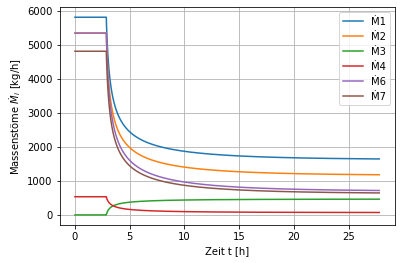

In [19]:
y_lists = [[M1_list, '\u1E401'], [M2_list, '\u1E402'], 
           [M3_list, '\u1E403'], [M4_list, '\u1E404'], 
           [M6_list, '\u1E406'], [M7_list, '\u1E407']]

plot_values(t_range, y_lists, 
            x_label='Zeit t [h]', 
            y_label = 'Massenstöme $\u1E40_{i}$ [kg/h]')

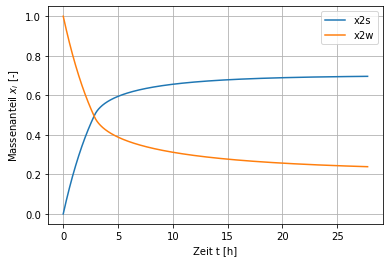

In [20]:
y_lists_x = [[x2s_list, 'x2s'], [x2w_list, 'x2w']]

plot_values(t_range, y_lists_x, 
            x_label='Zeit t [h]', y_label = 'Massenanteil $x_{i}$ [-]')